Install Packages

In [1]:
%pip install lightning
%pip install scikit-build
%pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 2.9 MB/s eta 0:00:00


Import Packages

In [2]:
import pytorch_lightning

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

import torch
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import requests
import zipfile
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from PIL import Image, ImageDraw, ImageFont
import random
from torchmetrics.classification import Accuracy
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

Get Data

In [3]:
#define root dir
root_dir = ''
print(root_dir)

# setup paths
data_dir = os.path.join(root_dir,"nist_dataset/")
data_resource = "https://s3.amazonaws.com/nist-srd/SD19/by_class.zip"
zip_dir = os.path.join(data_dir, "by_class.zip")
extracted_data_dir = os.path.join(data_dir, "extracted/")

# only download and extra if not already extracted
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

    with open(zip_dir, 'wb') as out_file:
        content = requests.get(data_resource, stream=True).content
        out_file.write(content)

    with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
        # list all files in the zip
        file_list = zip_ref.namelist()

        # unzip while showing progress
        with tqdm(total=len(file_list), desc="Extracting Files", unit="file") as progress_bar:
            for file in file_list:
                zip_ref.extract(file, extracted_data_dir)
                progress_bar.update(1)
else:
    print(f"Dataset already extracted at {extracted_data_dir}")

Extracting Files: 100%|██████████| 1546916/1546916 [02:47<00:00, 9247.56file/s]


Define the Dataset

In [4]:
class SingleCharacterDataset(Dataset):
    def __init__(self, image_names, labels, transform=None):
        self.transform = transform
        self.image_names = image_names
        self.labels = labels

        # Load all images into memory
        #self.images = [Image.open(iname).convert("L") for iname in image_names]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image = Image.open(self.image_names[idx]).convert('L')  # Ensure grayscale

        # Apply transform if given
        if self.transform:
            image = self.transform(image)

        # convert label to ascii and tensor
        label = self.labels[idx]
        label_tensor = torch.tensor(ord(label), dtype=torch.long)

        return image, label_tensor

Define the Model

In [10]:
class CharacterRecognitionModel(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        # setup network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # loss function and other metrics
        self.loss_function = nn.CrossEntropyLoss(reduction = "sum")

        self.best_val_loss = float('inf')
        self.best_val_epoch = 0
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.validation_step_outputs = []
        self.epoch = 0

        # try to use TensorBoard, but it's finicky
        self.layout = {
                "Training_Plots": {
                    "progress": ["Multiline", ["progress/loss_train", "progress/accuracy_train", "progress/loss_validation", "progress/accuracy_validation"]],
                },
            }

        self.summary_writer = SummaryWriter()
        self.summary_writer.add_custom_scalars(self.layout)

    # define how layers interact
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    # use the adam optimizer
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), 1e-2)
        return optimizer


    # dataset preparation
    def prepare_data(self):
        img_paths, labels = [], []

        ascii_folders = os.listdir(os.path.join(extracted_data_dir,"by_class"))
        for ascii_num in ascii_folders:
            # Convert folder name from hexadecimal to ASCII
            label = chr(int(ascii_num, 16))
            train_folder = os.path.join(extracted_data_dir,"by_class",f"{ascii_num}",f"train_{ascii_num}")

            if os.path.exists(train_folder):
                # Loop through each file in the train_folder
                for file in os.listdir(train_folder):
                    if file.endswith(".png"):
                        # Add full path to the list of image paths
                        img_paths.append(os.path.join(train_folder, file))
                        labels.append(label)

        print(f"Total samples: {len(img_paths)}")

        # Define the split ratios
        train_ratio = 0.8
        val_ratio = 0.1
        test_ratio = 0.1

        # Shuffle Dataset
        combined = list(zip(img_paths, labels))
        np.random.seed(67)
        np.random.shuffle(combined)
        img_paths, labels = zip(*combined)

        # Calculate split indices
        total_samples = len(img_paths)
        train_end = int(total_samples * train_ratio)
        val_end = train_end + int(total_samples * val_ratio)

        # Split the dataset
        train_img_paths = img_paths[:train_end]
        val_img_paths = img_paths[train_end:val_end]
        test_img_paths = img_paths[val_end:]

        train_labels = labels[:train_end]
        val_labels = labels[train_end:val_end]
        test_labels = labels[val_end:]

        print(f"Training samples: {len(train_img_paths)}")
        print(f"Validation samples: {len(val_img_paths)}")
        print(f"Test samples: {len(test_img_paths)}")

        # define the training data transforms
        train_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        val_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        test_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # setup data sets
        self.train_ds = SingleCharacterDataset(train_img_paths, train_labels, transform=train_transforms)
        self.val_ds = SingleCharacterDataset(val_img_paths, val_labels, transform=val_transforms)
        self.test_ds = SingleCharacterDataset(test_img_paths, test_labels, transform=test_transforms)

    # setup the training dataloader, here we choose the training batchsize and the number of workers
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds,
            batch_size=128,
            shuffle=True,
            num_workers=2,
            persistent_workers=True,
        )
        return train_loader

    # setup the validation dataloader
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val_ds,
                batch_size=128,
                num_workers=2,
                persistent_workers=True,
                )
        return val_loader

    # setup the test dataloader
    def test_dataloader(self):
        test_loader = DataLoader(
            self.test_ds,
                batch_size=128,
                num_workers=2,
                persistent_workers=True,
                )
        return test_loader


    def training_step(self, batch, batch_idx):
        images, labels = batch
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        self.train_accuracy.update(output, labels)
        self.log('train_loss', loss.item())
        self.log('train_accuracy', self.train_accuracy.compute())
        tensorboard_logs = {"train_loss": loss.item(), 'train_accuracy': self.train_accuracy.compute().cpu().numpy()}
        self.summary_writer.add_scalar("progress/loss_train",loss.item(),self.epoch)
        self.summary_writer.add_scalar("progress/accuracy_train",self.train_accuracy.compute().cpu().numpy(),self.epoch)
        self.epoch+=1
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images)
        loss = self.loss_function(outputs, labels)
        self.val_accuracy.update(outputs, labels)
        d = {"val_loss": loss, "val_number": len(outputs)}
        self.validation_step_outputs.append(d)

    def on_train_epoch_end(self):
        self.train_accuracy.reset()

    # this is called at the end of every validation epoch
    def on_validation_epoch_end(self):
        val_loss, num_items = 0, 0
        for output in self.validation_step_outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_loss = torch.tensor(val_loss / num_items)

        tensorboard_logs = {
            "val_loss": mean_val_loss,
            "val_accuracy": self.val_accuracy.compute().cpu().numpy(),
        }
        self.log('val_loss', mean_val_loss)
        self.log('val_accuracy', self.val_accuracy.compute())
        self.summary_writer.add_scalar("progress/loss_validation",mean_val_loss.item(),self.epoch)
        self.summary_writer.add_scalar("progress/accuracy_validation",self.val_accuracy.compute().cpu().numpy(),self.epoch)
        if mean_val_loss < self.best_val_loss:
            self.best_val_loss = mean_val_loss
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"\nbest mean loss: {self.best_val_loss:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.validation_step_outputs.clear()
        self.val_accuracy.reset()
        return {"log": tensorboard_logs}

Train the Model

In [12]:
from pytorch_lightning import Trainer

# Initialize the model and data module
num_classes = 128  # we have 128 classes

# initialise the Networking using PyTorch Lightning
net = CharacterRecognitionModel(num_classes=num_classes)

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)

# early stopping
#early_stop_callback = EarlyStopping(monitor="val_accuracy", min_delta=0.00, patience=3, verbose=False, mode="max")

# initialise PyTorch Lightning's trainer
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=5,
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=1,
    enable_progress_bar= True,
    #callbacks=[early_stop_callback],
)

# train the network
trainer.fit(net)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Total samples: 731668


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | fc1            | Linear             | 2.1 M  | train
4 | fc2            | Linear             | 16.5 K | train
5 | loss_function  | CrossEntropyLoss   | 0      | train
6 | train_accuracy | MulticlassAccuracy | 0      | train
7 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.530     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training samples: 585334
Validation samples: 73166
Test samples: 73168


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

current epoch: 0 
best mean loss: 4.8333 at epoch: 0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 0 
best mean loss: 0.3953 at epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 1 
best mean loss: 0.3526 at epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 2 
best mean loss: 0.3428 at epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 3 
best mean loss: 0.3428 at epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


current epoch: 4 
best mean loss: 0.3413 at epoch: 4


Continue Training on Prev Checkpoint

In [13]:
# continue training if interrupted
net = CharacterRecognitionModel(num_classes=num_classes)
# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(save_dir=log_dir)
trainer = pytorch_lightning.Trainer(
    devices=[0],
    max_epochs=10,
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=1,
    log_every_n_steps=1,
    enable_progress_bar= True,
)
trainer.fit(net, ckpt_path='logs/lightning_logs/version_4/checkpoints/epoch=4-step=22865.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Total samples: 731668
Training samples: 585334
Validation samples: 73166
Test samples: 73168


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_4/checkpoints/epoch=4-step=22865.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:362: The dirpath has changed from 'logs/lightning_logs/version_4/checkpoints' to 'logs/lightning_logs/version_5/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | fc1            | Linear             | 2.1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

current epoch: 4 
best mean loss: 0.2454 at epoch: 4


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 5 
best mean loss: 0.2454 at epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 6 
best mean loss: 0.2454 at epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 7 
best mean loss: 0.2454 at epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

current epoch: 8 
best mean loss: 0.2454 at epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


current epoch: 9 
best mean loss: 0.2454 at epoch: 4


Check Validation and Test on Previous Checkpoint

In [14]:
# load net
checkpoint_location = "logs/lightning_logs/version_2/checkpoints/epoch=29-step=137190.ckpt"
net = CharacterRecognitionModel.load_from_checkpoint(checkpoint_location, num_classes=num_classes)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# load the network into the GPU
net.eval()
device = torch.device("cuda:0")
net.to(device)
net.prepare_data()

test_dataloader = DataLoader(net.test_ds, batch_size = 1)


# first check the forward prediction times without calculating statistics
import time
prev_time = time.time()
num_samps = 0
time_c = []
all_preds = []
all_outputs = []
all_labels = []
all_images = []
with torch.no_grad():
  with tqdm(total=len(test_dataloader), desc="Processing Test Data", unit="ii") as progress_bar:
    for test_data in test_dataloader:
        images, labels = test_data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net.forward(images)
        preds = outputs.max(1).indices

        all_outputs.append(outputs.detach().cpu().numpy())
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())
        all_images.append(images.detach().cpu().numpy())

        num_samps+=1
        time_c.append(time.time() - prev_time)
        prev_time = time.time()
        if num_samps % 1000 == 0:
          progress_bar.update(1000)
time_c = np.asarray(time_c)

all_preds = np.asarray(all_preds)
all_outputs = np.asarray(all_outputs)
all_labels = np.asarray(all_labels)
all_images = np.asarray(all_images)

# print time metrics
print(f"Val Pred Time: {time_c.mean():.4f}, +- {time_c.std():.4f}")


Total samples: 731668
Training samples: 585334
Validation samples: 73166
Test samples: 73168



Processing Test Data: 100%|█████████▉| 73000/73168 [01:58<00:00, 618.55ii/s]


Val Pred Time: 0.0016, +- 0.0041


Make Other Statistics

tensor(0.8815)


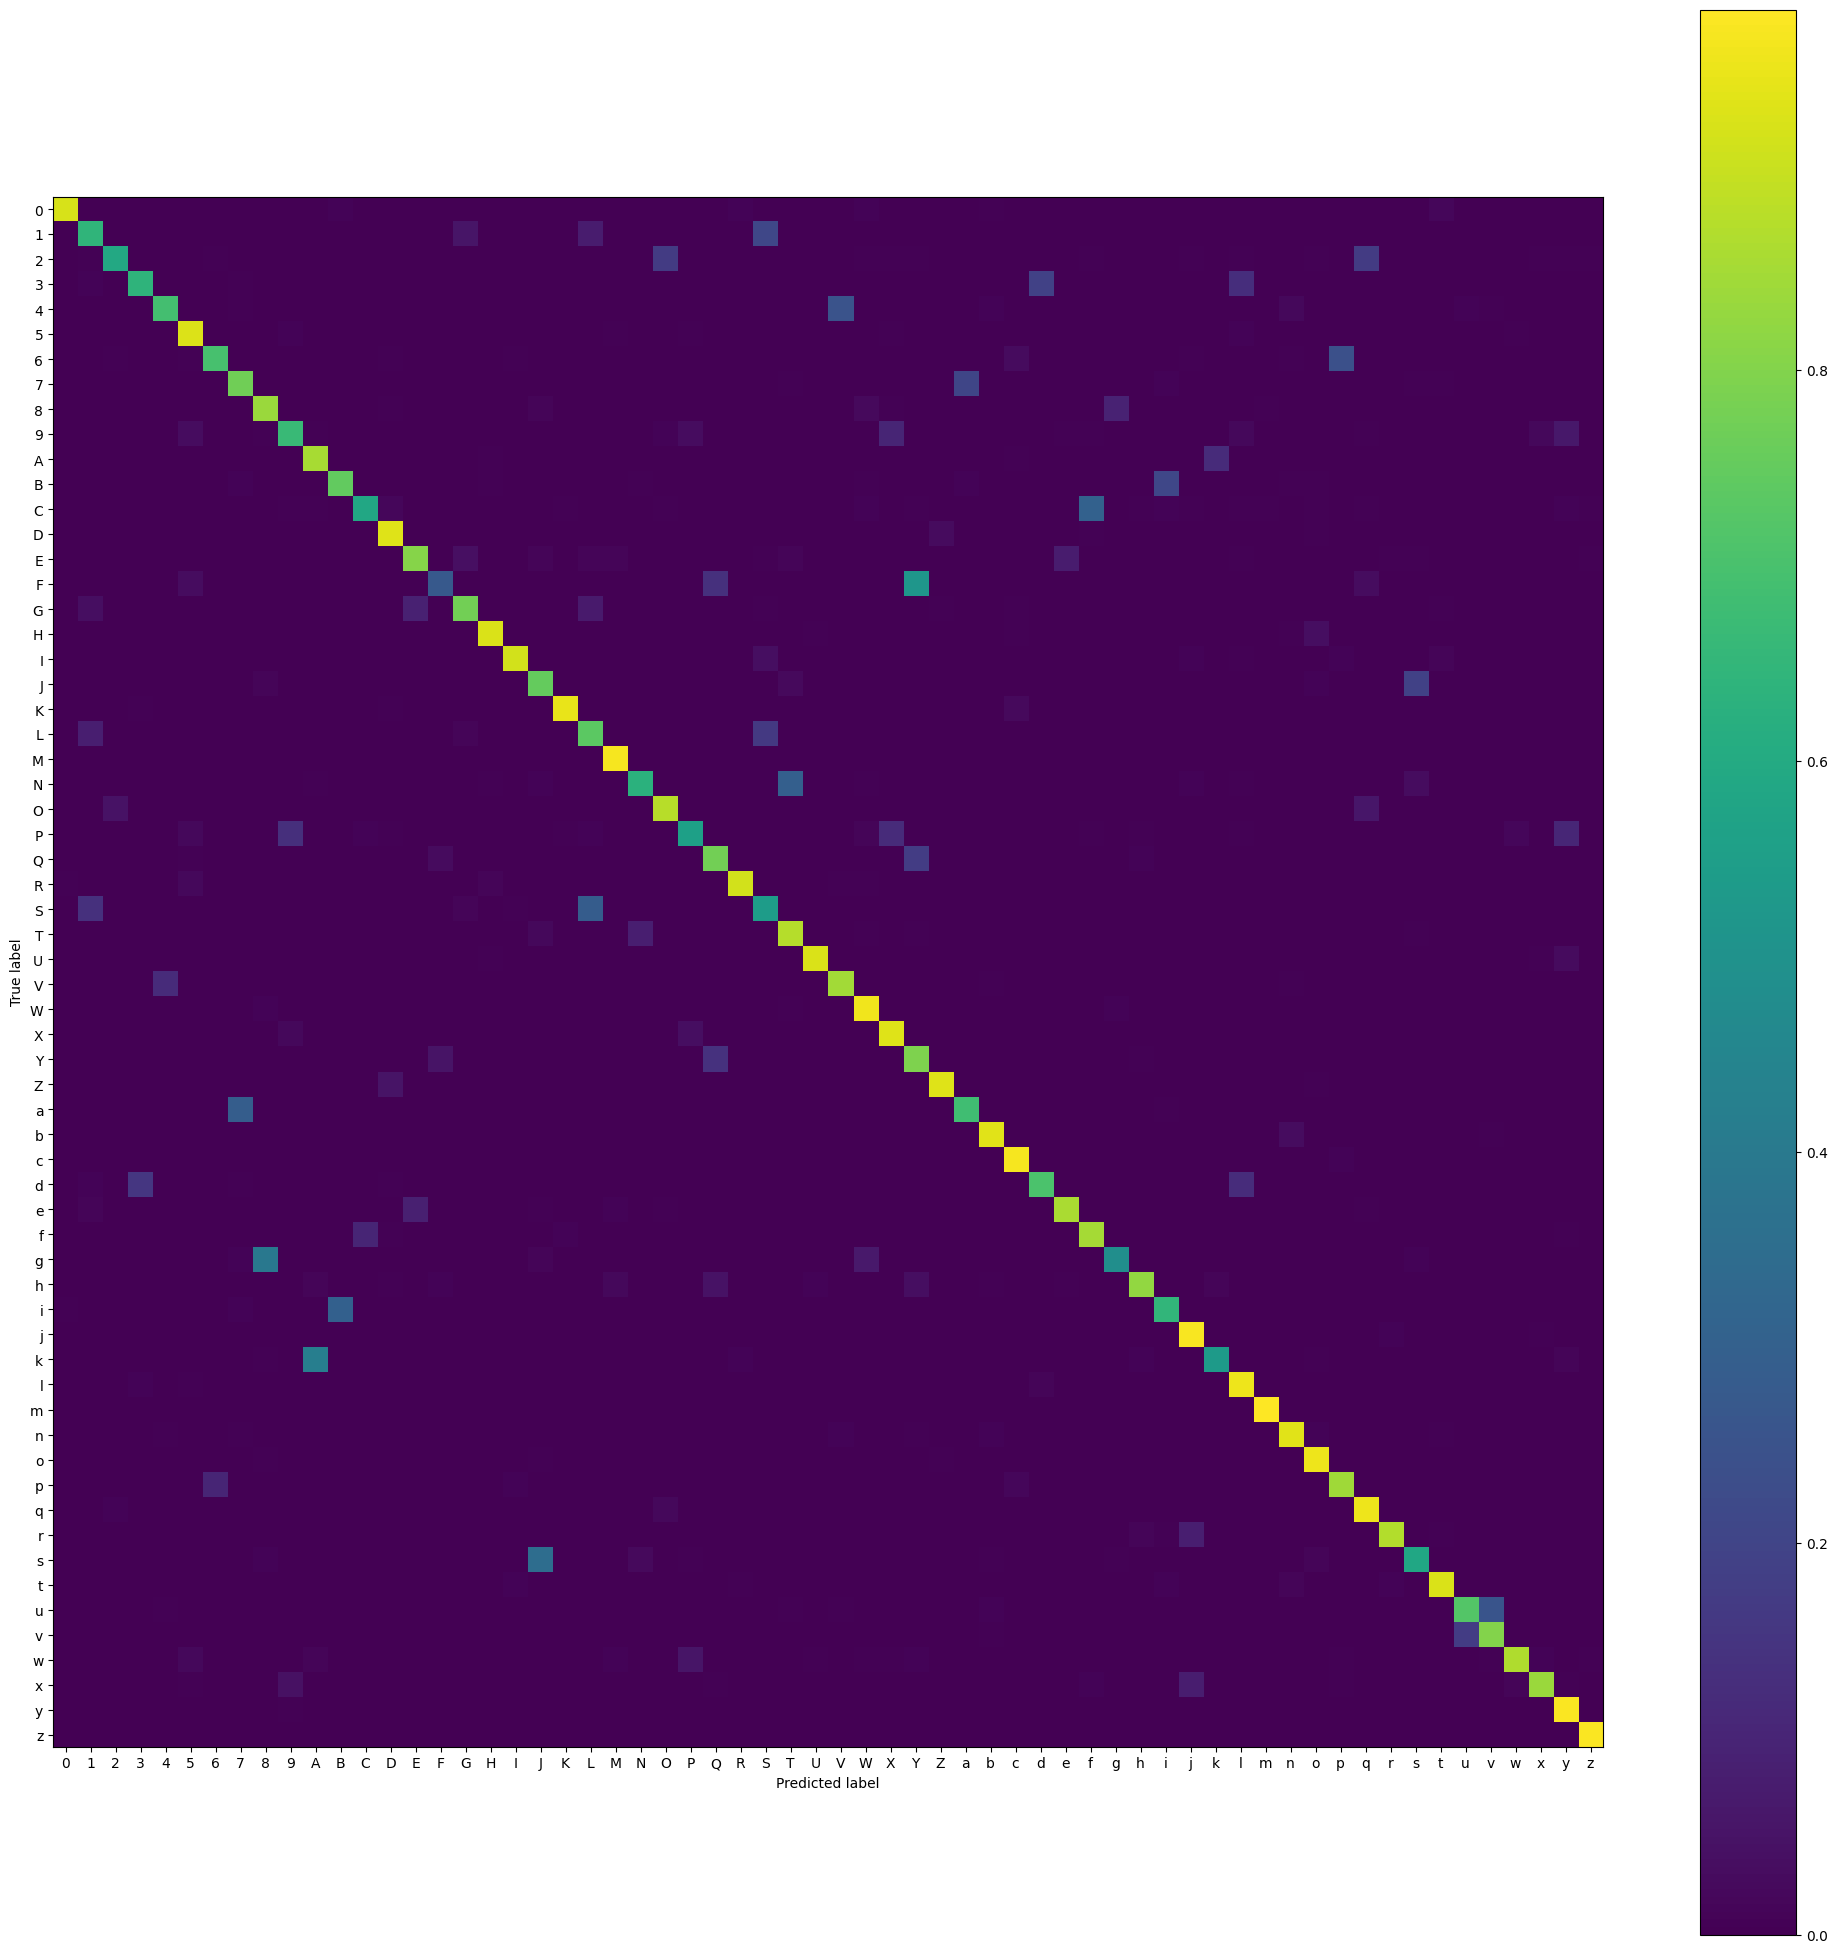

In [26]:
# make confusion plot and calculate accuracy

ascii_folders = os.listdir(os.path.join(extracted_data_dir,"by_class"))
letter_labels = np.asarray([chr(int(ll,16)) for ll in ascii_folders])

ordered_indices = np.argsort(letter_labels)
letter_labels = letter_labels[ordered_indices]

cm = confusion_matrix(all_preds, all_labels, normalize = "true")
cm = cm[ordered_indices, :]
cm = cm[:, ordered_indices]
fig, ax = plt.subplots(figsize=(25, 25))

ConfusionMatrixDisplay(cm, display_labels = letter_labels).plot(ax = ax, include_values = False)


test_accuracy = Accuracy(task="multiclass", num_classes=128)
test_accuracy.update(torch.asarray(all_outputs.swapaxes(1,2)), torch.asarray(all_labels))
t_acc = test_accuracy.compute()
print(t_acc)